In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysam
import itertools
import duckdb
from upsetplot import from_memberships, plot

In [2]:
# Disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
tools = ['flair', 'isoquant', 'isotools_v0', 'stringtie']
# tools = ['isoquant', 'isotools_v0', 'isotools_v1', 'isotools_v2']
# tools = ['isotools_v0', 'isotools2']
tissue = 'brain'

In [4]:
max_isotools_suffix = max([int(t.replace('isotools_v', '')) for t in tools if 'isotools_v' in t])

In [5]:
gtf_path = "/project/hfa_work/ENCODE/code/snakemake-pipeline/results/{tool}/transcriptome/{tissue}_sorted.gtf.gz"

In [6]:
def get_tabix(tool, tissue):
    if tool == 'isotools2':
        tool = 'isotools_v0'
    return pysam.TabixFile(gtf_path.format(tool=tool, tissue=tissue))

In [7]:
tss_error = 0
pas_error = 0
junction_error = 0

In [8]:
def tool_transcriptome(tool):
    transcripts = []
    exon_list = []
    exon_count = {}
    tabix = get_tabix(tool, tissue)
    for row in tabix.fetch(parser=pysam.asGTF()):
        if row.feature == "transcript":
            transcripts.append((row.transcript_id, row.contig, int(row.start), int(row.end), row.strand))
        elif row.feature == "exon":
            exon_count.setdefault(row.transcript_id, 0)
            exon_list.extend([
                (row.transcript_id, 2 * exon_count[row.transcript_id], int(row.start)),
                (row.transcript_id, 2 * exon_count[row.transcript_id] + 1, int(row.end))])
            exon_count[row.transcript_id] += 1

    transcriptome = pd.DataFrame(transcripts, columns=["transcript_id", "chr", "start", "end", "strand"])
    transcriptome["min_start"] = np.where(transcriptome["strand"] == '+', transcriptome["start"] - tss_error, transcriptome["start"] - pas_error)
    transcriptome["max_start"] = np.where(transcriptome["strand"] == '+', transcriptome["start"] + tss_error, transcriptome["start"] + pas_error)
    transcriptome["min_end"] = np.where(transcriptome["strand"] == '+', transcriptome["end"] - pas_error, transcriptome["end"] - tss_error)
    transcriptome["max_end"] = np.where(transcriptome["strand"] == '+', transcriptome["end"] + pas_error, transcriptome["end"] + tss_error)

    exons = pd.DataFrame(exon_list, columns=["transcript_id", "index", "position"])
    transcriptome.set_index("transcript_id", inplace=True)
    transcriptome["max_splice_site_index"] = exons.groupby("transcript_id").max()["index"]
    transcriptome.reset_index(inplace=True, names=["transcript_id"])

    transcriptome.to_csv(f"results/{tool}_transcriptome.tsv", sep="\t", index=False)

    exons.to_csv(f"results/{tool}_exons.tsv", sep="\t", index=False)

    return transcriptome, exons


def add_transcript_overlap_duckdb(tool, tool_overlap, overlap_exons, remove_duplicates=True):
    transcriptome, new_exons = tool_transcriptome(tool)

    if tool_overlap.empty:
        tool_overlap = pd.concat([tool_overlap, transcriptome])
        tool_overlap[tool] = transcriptome["transcript_id"]
        tool_overlap["id"] = tool + transcriptome["transcript_id"]
        tool_overlap.drop(columns=["transcript_id"], inplace=True)

        new_exons['id'] = tool + new_exons["transcript_id"]
        new_exons.drop(columns=["transcript_id"], inplace=True)
        overlap_exons = pd.concat([overlap_exons, new_exons])

        return tool_overlap, overlap_exons

    query = f"""
SELECT
    tool_ol.id,
    t.transcript_id
FROM tool_overlap AS tool_ol
JOIN transcriptome t ON
    tool_ol.chr = t.chr AND
    tool_ol.start >= t.min_start AND
    tool_ol.start <= t.max_start AND
    tool_ol.end >= t.min_end AND
    tool_ol.end <= t.max_end AND
    tool_ol.strand = t.strand AND
    tool_ol.max_splice_site_index = t.max_splice_site_index
JOIN new_exons ne ON
    ne.transcript_id = t.transcript_id
JOIN overlap_exons oe ON
    oe.id = tool_ol.id AND
    oe.index = ne.index AND
    (
        ABS(oe.position - ne.position) <= {junction_error} OR
        oe.index = 0 OR
        oe.index = t.max_splice_site_index
    )
GROUP BY
    tool_ol.id,
    t.transcript_id
HAVING
    COUNT(*) = MAX(t.max_splice_site_index) + 1
               """

    matches = duckdb.sql(query).df()
    # print("matches", matches)
    # print("tool_overlap", tool_overlap)
    # print("transcriptome", transcriptome)

    # Happens when multiple transcripts from the new tool match the same transcript from the previous tools
    # or when a transcript from the new tool matches multiple transcripts from the previous tools
    if remove_duplicates:
        print("with duplicates:", matches.shape)
        matches = matches.drop_duplicates(subset=["id"]).drop_duplicates(subset=["transcript_id"])
        print("without duplicates", matches.shape)

    # Add matches to the df
    tool_overlap = tool_overlap.merge(matches, on="id", how="left")
    tool_overlap[tool] = tool_overlap["transcript_id"]
    tool_overlap.drop(columns=["transcript_id"], inplace=True)

    # Add mismatches to the df
    transcriptome_filtered = transcriptome.set_index("transcript_id").drop(matches["transcript_id"].to_list()).reset_index(names=["transcript_id"])
    transcriptome_filtered[tool] = transcriptome_filtered["transcript_id"]
    transcriptome_filtered["id"] = tool + transcriptome_filtered["transcript_id"]
    transcriptome_filtered.drop(columns=["transcript_id"], inplace=True)
    tool_overlap = pd.concat([tool_overlap, transcriptome_filtered])
    tool_overlap.to_csv("results/overlap.tsv", sep="\t")

    # Add exons for mismatches
    new_exons['id'] = tool + new_exons["transcript_id"]
    new_exons.drop(columns=["transcript_id"], inplace=True)
    # Filter new_exons to only contain exons of transcriptome_filtered
    new_exons = new_exons[new_exons["id"].isin(transcriptome_filtered["id"])]
    overlap_exons = pd.concat([overlap_exons, new_exons])
    overlap_exons.to_csv("results/overlap_exons.tsv", sep="\t")

    return tool_overlap, overlap_exons

overlap = pd.DataFrame(columns=["chr", "start", "end", "strand", "max_splice_site_index", *tools])
overlap_exons = pd.DataFrame(columns=["id", "index", "position"])

for tool in tools:
    print("Processing", tool)
    overlap, overlap_exons = add_transcript_overlap_duckdb(tool, overlap, overlap_exons, remove_duplicates=False)

Processing flair
Processing isoquant


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing isotools_v0


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing stringtie


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [9]:
overlap

,chr,start,end,strand,max_splice_site_index,flair,isoquant,isotools_v0,stringtie,min_start,max_start,min_end,max_end,id
0,chr1,14362,24886,-,19,ENST00000488147.2,NaN,NaN,NaN,14362.0,14362.0,24886.0,24886.0,flairENST00000488147.2
1,chr1,14362,24886,-,15,m64109_220205_045735/42860751/ccs,NaN,NaN,NaN,14362.0,14362.0,24886.0,24886.0,flairm64109_220205_045735/42860751/ccs
2,chr1,14362,24886,-,17,m64109_220205_045735/69337600/ccs,NaN,NaN,NaN,14362.0,14362.0,24886.0,24886.0,flairm64109_220205_045735/69337600/ccs
3,chr1,14406,195411,-,13,m64109_220205_045735/17303320/ccs,NaN,NaN,NaN,14406.0,14406.0,195411.0,195411.0,flairm64109_220205_045735/17303320/ccs
4,chr1,14406,195411,-,15,m64109_220212_045432/22544972/ccs,NaN,NaN,NaN,14406.0,14406.0,195411.0,195411.0,flairm64109_220212_045432/22544972/ccs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277359,chrY,57209305,57210276,+,3,NaN,NaN,NaN,ENST00000711282.1,57209305.0,57209305.0,57210276.0,57210276.0,stringtieENST00000711282.1
277360,chrY,57209886,57212230,+,3,NaN,NaN,NaN,ENST00000711283.1,57209886.0,57209886.0,57212230.0,57212230.0,stringtieENST00000711283.1
277361,chrY,57210343,57212230,+,5,NaN,NaN,NaN,ENST00000711284.1,57210343.0,57210343.0,57212230.0,57212230.0,stringtieENST00000711284.1
277362,chrY,57210590,57212230,+,5,NaN,NaN,NaN,ENST00000711285.1,57210590.0,57210590.0,57212230.0,57212230.0,stringtieENST00000711285.1


In [10]:
# iterate over all combination of tools and count the number of transcripts that are shared
combinations = itertools.chain.from_iterable(itertools.combinations(tools, r) for r in range(1, len(tools) + 1))

counts = []
for combination in combinations:
    inverted_combination = [tool for tool in tools if tool not in combination]
    counts.append((combination,
                   overlap[[*combination]].dropna().shape[0],
                   overlap[(overlap[inverted_combination].isna().all(axis=1)) & (overlap[[*combination]].notna().all(axis=1))].shape[0]))

counts = pd.DataFrame(counts, columns=["tools", "shared", "unique"])
if max_isotools_suffix == 0:
    # Replace isotools_v0 with isotools
    counts["tools"] = counts["tools"].apply(lambda x: tuple([t.replace('isotools_v0', 'isotools') for t in x]))
counts

,tools,shared,unique
0,"(flair,)",145039,133381
1,"(isoquant,)",42331,29274
2,"(isotools,)",55371,54624
3,"(stringtie,)",296819,277364
4,"(flair, isoquant)",3365,1226
5,"(flair, isotools)",696,661
6,"(flair, stringtie)",9762,7616
7,"(isoquant, isotools)",45,24
8,"(isoquant, stringtie)",11798,9666
9,"(isotools, stringtie)",53,25


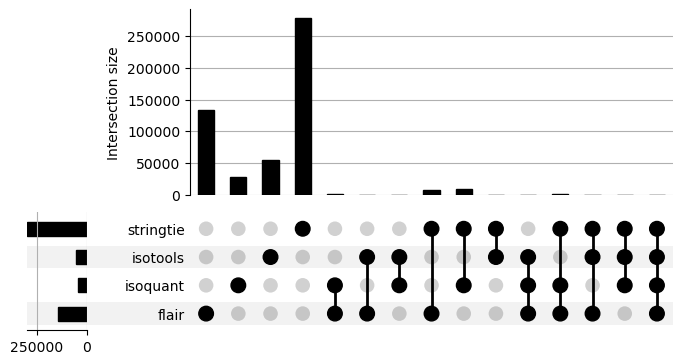

In [11]:
upset = from_memberships(counts["tools"].to_list(), data=counts["unique"].to_list())
plot(upset, sort_categories_by='input', orientation='horizontal', element_size=30)

plt.savefig(f"results/upset_{"_".join(tools)}.png")
plt.show()

In [12]:
upset

flair  isoquant  isotools  stringtie
True   False     False     False        133381
False  True      False     False         29274
       False     True      False         54624
                 False     True         277364
True   True      False     False          1226
       False     True      False           661
                 False     True           7616
False  True      True      False            24
                 False     True           9666
       False     True      True             25
True   True      True      False             9
                 False     True           2120
       False     True      True             16
False  True      True      True              2
True   True      True      True             10
dtype: int64

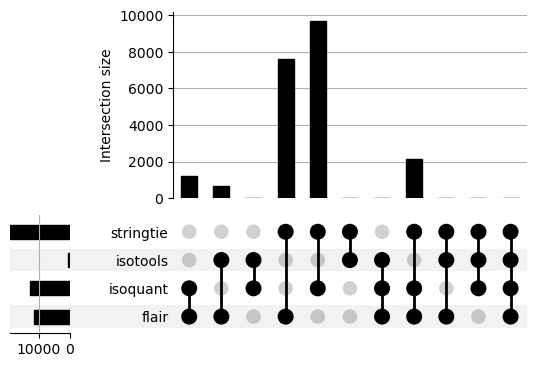

In [13]:
# remove stringtie and flair unique entries
counts_filtered = counts[counts["tools"].apply(len) > 1]
upset = from_memberships(counts_filtered["tools"].to_list(), data=counts_filtered["unique"].to_list())
plot(upset, sort_categories_by='input', orientation='horizontal', element_size=30)
plt.savefig(f"results/upset_filtered_{"_".join(tools)}.png")
plt.show()

In [14]:
if 'isotools2' in tools:
    doubled = overlap[overlap['isotools_v0'] != overlap['isotools2']]
else:
    doubled = None
doubled